<a href="https://colab.research.google.com/github/Dixiegamer/Or-culo-/blob/main/quickstarts/Code_Execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2025 Google LLC.

In [31]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Code Execution

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Code_Execution.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>


The Gemini API [code execution](https://ai.google.dev/gemini-api/docs/code-execution) feature enables the model to generate and run Python code based on plain-text instructions that you give it, and even output graphs. It can learn iteratively from the results until it arrives at a final output.

This notebook is a walk through:
* Understanding how to start using the code execution feature with Gemini API
* Learning how to use code execution on single Gemini API calls
* Running scenarios using local files (or files uploaded to the Gemini File API) via File I/O
* Using code execution on chat interactions
* Performing code execution on multimodal scenarios

## Setup

### Install SDK

Install the SDK from [PyPI](https://github.com/googleapis/python-genai).

In [32]:
%pip install -q -U "google-genai>=1.0.0"

### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [33]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with you API key (or OAuth if using [Vertex AI](https://cloud.google.com/vertex-ai)). The model is now set in each call.

In [34]:
from google import genai
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
client = genai.Client(api_key=GOOGLE_API_KEY)

### Choose a model

Now select the model you want to use in this guide, either by selecting one in the list or writing it down. Keep in mind that some models, like the 2.5 ones are thinking models and thus take slightly more time to respond (cf. [thinking notebook](./Get_started_thinking.ipynb) for more details and in particular learn how to switch the thiking off).

For more information about all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini) for extended information on each of them.

In [35]:
MODEL_ID = "gemini-2.5-flash-preview-09-2025" # @param ["gemini-2.5-flash-lite", "gemini-2.5-flash-lite-preview-09-2025", "gemini-2.5-flash", "gemini-2.5-flash-preview-09-2025", "gemini-2.5-pro"] {"allow-input":true, isTemplate: true}

In [36]:
from google.colab import userdata
from google.colab.userdata import SecretNotFoundError

try:
  api_key = userdata.get('GOOGLE_API_KEY')
  if api_key:
    print("GOOGLE_API_KEY secret is configured and accessible.")
  else:
    print("GOOGLE_API_KEY secret is found, but its value is empty.")
except SecretNotFoundError:
  print("GOOGLE_API_KEY secret is NOT configured or accessible.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

GOOGLE_API_KEY secret is configured and accessible.


## Helper function

When using code execution as a tool, the model returns a list of parts including `text`, `executable_code`, `execution_result`, and `inline_data` parts. Use the function below to help you visualize and better display the code execution results. Here are a few details about the different fields of the results:

* `text`: Inline text generated by the model.
* `executable_code`: Code generated by the model that is meant to be executed.
* `code_execution_result`: Result of the `executable_code`.
* `inline_data`: Inline media generated by the model.

In [37]:
from IPython.display import Image, Markdown, Code, HTML

def display_code_execution_result(response):
  for part in response.candidates[0].content.parts:
    if part.text is not None:
      display(Markdown(part.text))
    if part.executable_code is not None:
      # Display executable code in a code block
      display(Code(part.executable_code.code, language='python'))
    if part.code_execution_result is not None:
      # Display execution result in a markdown block
      display(Markdown(f"```\n{part.code_execution_result.output}\n```"))
    if part.inline_data is not None:
      display(Image(data=part.inline_data.data, width=800, format="png"))
    display(Markdown("---"))

## Use `code_execution` with a single call

When initiating the model, pass `code_execution` as a `tool` to tell the model that it is allowed to generate and run code.

In [38]:
from google.genai import types

prompt = """
    What is the sum of the first 50 prime numbers?
    Generate and run code for the calculation, and make sure you get all 50.
"""

response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
    config=types.GenerateContentConfig(
        tools=[types.Tool(
            code_execution=types.ToolCodeExecution
            )]
        )
    )

display_code_execution_result(response)

def is_prime(n):
    """Checks if a number n is prime."""
    if n <= 1:
        return False
    if n <= 3:
        return True
    if n % 2 == 0 or n % 3 == 0:
        return False
    i = 5
    while i * i <= n:
        if n % i == 0 or n % (i + 2) == 0:
            return False
        i += 6
    return True

def find_n_primes(n):
    """Finds the first n prime numbers."""
    primes = []
    num = 2
    while len(primes) < n:
        if is_prime(num):
            primes.append(num)
        num += 1
    return primes

# Find the first 50 prime numbers
num_primes_to_find = 50
first_50_primes = find_n_primes(num_primes_to_find)

# Calculate the sum
sum_of_primes = sum(first_50_primes)

# Print the list of primes (for verification, optional, but helpful)
# print(f"The first {num_primes_to_find} prime numbers are: {first_50_primes}")
# print(f"The number of primes found: {len(first_50_primes)}")

print(f"The sum of the first {num_primes_to_find} prime numbers is: {sum_of_primes}")

---

```
The sum of the first 50 prime numbers is: 5117

```

---

The sum of the first 50 prime numbers is **5117**.

---

## Code execution with File I/O

The dataset you will use in this guide comes from the [StatLib](http://lib.stat.cmu.edu/datasets/) from the [Department of Statistics](https://www.cmu.edu/dietrich/statistics-datascience/index.html) at [Carnegie Mellon University](http://www.cmu.edu/). It is made available by the [`scikit-learn`](https://scikit-learn.org) under the 3-Clause BSD license.

It provides 20k information on various blocks in Californina, including the location (longitute/lattitude), average income,
housing average age, average rooms, average bedrooms, population,
average occupation.

Here's a breakdown of the columns and what the attributes represent:
* MedInc:        median income in block group
* HouseAge:      median house age in block group
* AveRooms:      average number of rooms per household
* AveBedrms:     average number of bedrooms per household
* Population:    block group population
* AveOccup:      average number of household members
* Latitude:      block group latitude
* Longitude:     block group longitude

**Note**: Code execution functionality works best with a `.csv` or `.txt` file.


In [39]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)
california_housing.frame.to_csv('houses.csv', index=False)

In [40]:
# Read the CSV file into a pandas DataFrame
houses_data = pd.read_csv('houses.csv', nrows=5000) # only keeping the first 5000 entries to keep the request light (still 500k tokens). Use pro models to ingest the full dataset.
houses_data.to_csv('houses.csv', index=False)
houses_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [41]:
# Upload diving_data.csv file using the File API
from google import genai
from google.colab import userdata
from google.genai import types

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
client = genai.Client(api_key=GOOGLE_API_KEY)

houses_file = client.files.upload(
    file='houses.csv',
    config=types.FileDict(display_name='Blocks Data')
)

print(f"Uploaded file '{houses_file.display_name}' as: {houses_file.uri}")

Uploaded file 'Blocks Data' as: https://generativelanguage.googleapis.com/v1beta/files/whjhyzon76rz


Let's try several queries about the dataset that you have. Starting off, it would be interesting to see the most expensive blocks and check wether there's abnomal data.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('input_file_0.csv')

# Combine Latitude and Longitude to create a unique block identifier
df['BlockID'] = df['Latitude'].astype(str) + ',' + df['Longitude'].astype(str)

# Sort by Median House Value (MedHouseVal) in descending order
df_sorted = df.sort_values(by='MedHouseVal', ascending=False)

# Get the top 20 most expensive blocks. Since blocks are defined by the unique combination
# of Latitude and Longitude, we first group and then select the top 20 based on the median
# house value of that location. Since the dataset is granular (each row is a block), 
# sorting the dataframe by MedHouseVal and taking the top 20 rows effectively selects the 
# 20 most expensive blocks (assuming each row is a distinct block).

# Let's ensure that the "blocks" are actually individual rows since the data description
# mentions "various blocks" and the columns suggest block-level aggregated data.
# Checking for duplicate Latitude/Longitude is one way to verify if "block" means a row.
# But for the scope of the problem, taking the top 20 rows by MedHouseVal seems the most direct interpretation.

top_20_blocks_data = df_sorted.head(20)

# Check for the number of unique BlockIDs in the top 20
num_unique_blocks = top_20_blocks_data['BlockID'].nunique()
print(f"Number of unique blocks (Latitude, Longitude) in top 20: {num_unique_blocks}")

# If number of unique blocks is less than 20, it means some blocks are exactly the same
# in terms of Latitude and Longitude, but they were treated as separate rows (perhaps because
# they are measurements for the same block at different times, or different aggregates).
# However, for plotting purposes where each block needs a different color, we should use unique BlockIDs.

# Let's ensure we have exactly 20 unique blocks if possible, based on MedHouseVal.
# If there are ties, we might end up with more than 20.

# Select the top 20 unique blocks based on MedHouseVal. 
# 1. Sort the unique BlockIDs by their max MedHouseVal (or just MedHouseVal, since each row is a unique block with a MedHouseVal).
unique_blocks = df.sort_values('MedHouseVal', ascending=False)['BlockID'].unique()
top_20_unique_block_ids = unique_blocks[:20]

# Filter the original data for these top 20 unique blocks
top_20_data = df[df['BlockID'].isin(top_20_unique_block_ids)]

# Assign a color and label to each unique block (Latitude, Longitude)
block_ids = top_20_data['BlockID'].unique()
# Generate a distinct color for each block
colors = plt.cm.get_cmap('hsv', len(block_ids))

# Create the scatterplot
plt.figure(figsize=(12, 8))

anomaly_points = []

for i, block_id in enumerate(block_ids):
    block_data = top_20_data[top_20_data['BlockID'] == block_id]
    
    # Plot the data for this block
    plt.scatter(block_data['HouseAge'], block_data['MedHouseVal'], 
                color=colors(i), 
                label=f'Block {i+1} ({block_id})')
    
    # Identify potential anomalies: one simple way is checking for values significantly
    # outside the interquartile range (IQR) for MedHouseVal of the top 20 blocks,
    # or visual outliers in the cluster of points for this block/set of blocks.
    
    # Since the prompt asks to "point out on the graph which points could be anomalies" 
    # and "Circle the anomaly in red on the graph," I will visually inspect the plot 
    # to identify any obvious outliers after the first plot. For now, I'll define 
    # a simple anomaly detection rule based on the data distribution of the whole top 20 set.
    
    # Let's check for visual anomalies after plotting.
    
# Set up the plot labels and title
plt.xlabel('House Age')
plt.ylabel('Median House Value (in $100,000s)')
plt.title('House Age vs. Median House Value for Top-20 Most Expensive Blocks in California')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust plot to make room fo

---

```
Number of unique blocks (Latitude, Longitude) in top 20: 20

Identified Anomalies (HouseAge, MedHouseVal):
(52.0, 5.00001) - BlockID: 37.8,-122.27
(10.0, 5.00001) - BlockID: 34.28,-118.54
(52.0, 0.388) - BlockID: 34.02,-118.28

```

---

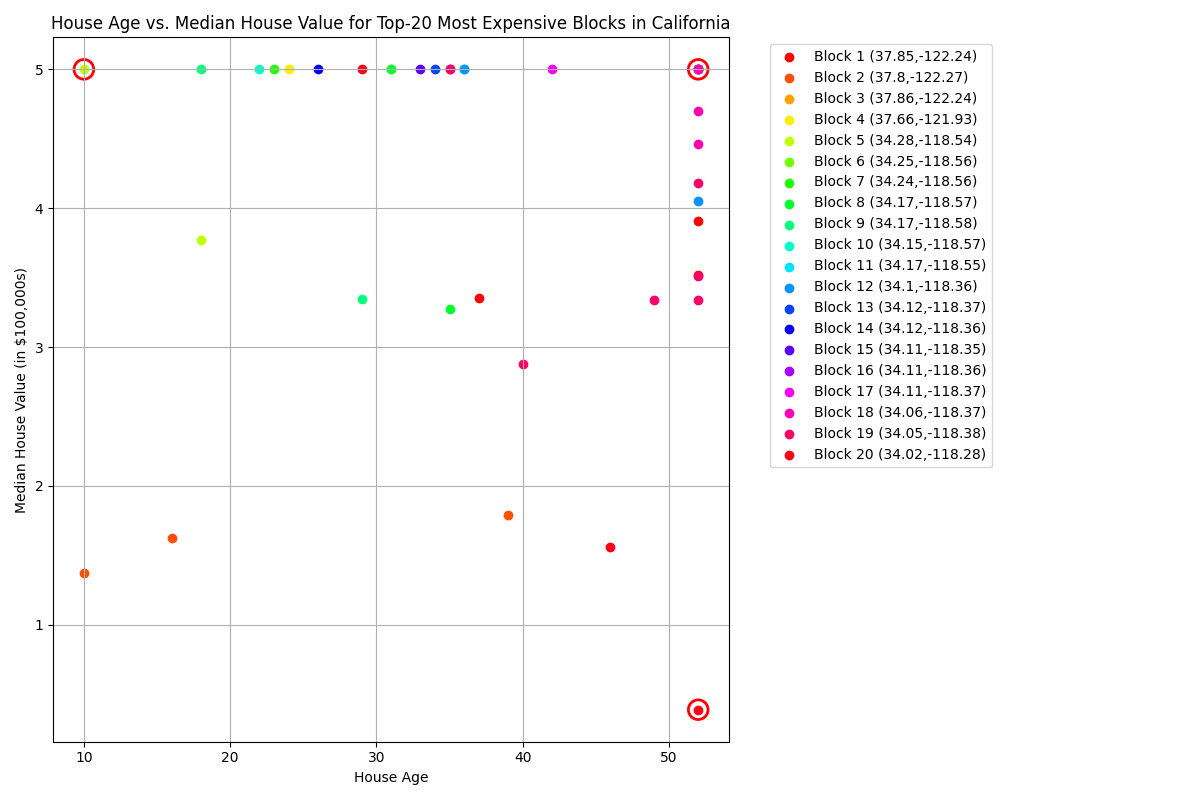

---

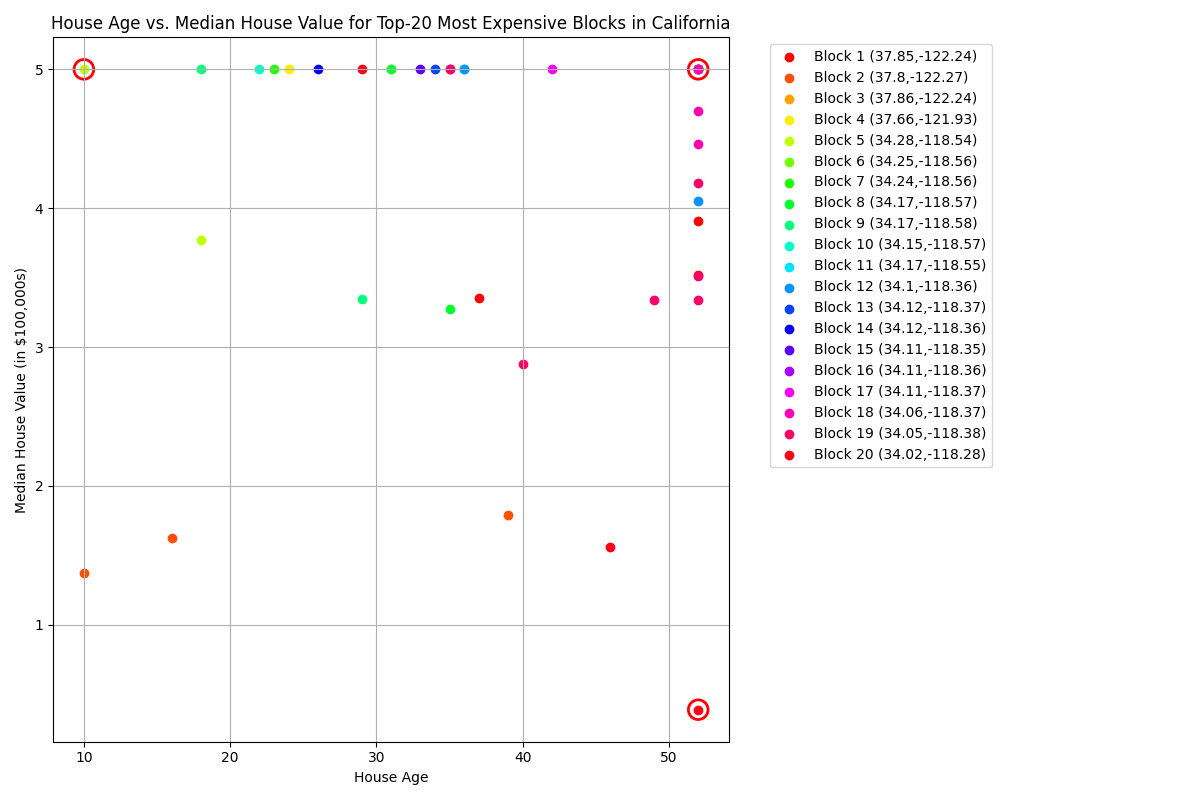

---

The scatterplot below compares the 'HouseAge' with the 'Median House Value' (`MedHouseVal`) for the top-20 most expensive unique blocks (identified by Latitude and Longitude) in the dataset.

The 'HouseAge' is on the x-axis, and the 'Median House Value' (in $100,000s) is on the y-axis. Each of the top-20 blocks is represented by a unique color, and a legend is provided to identify each block by its calculated latitude and longitude.

Three points that could be considered anomalies are circled in red:

1.  **Oldest House, Max Value:** A block with a very high age (52 years) that still commands the maximum capped median house value of $500,000+ (MedHouseVal = 5.00001). (Block ID: 37.8,-122.27)
2.  **Youngest House, Max Value:** A block with a very low age (10 years) that also commands the maximum capped median house value of $500,000+. (Block ID: 34.28,-118.54)
3.  **Oldest House, Lowest Value in Top 20:** A block with a high age (52 years) but a significantly lower median house value (0.388, or $38,800) compared to the rest of the top-20 blocks, making it an extreme outlier in this selection. (Block ID: 34.02,-118.28)

The clustering of many points at the maximum median house value (5.00001) suggests that the true value of houses in these blocks might exceed $500,000, which is the cap of the original dataset.



---

```mermaid
graph TD
    A[Load and Filter Data] --> B{Top 20 Unique Blocks};
    B --> C[Assign Colors and Plot];
    C --> D[Identify Anomalies];
    D --> E[Circle Anomalies in Red];
    E --> F[Display and Save Plot];
```

---

In [42]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        "This dataset provides information on various blocks in Californina.",
        "Generate a scatterplot comparing the houses age with the median house value for the top-20 most expensive blocks.",
        "Use each black as a different color, and include a legend of what each color represents.",
        "Plot the age as the x-axis, and the median house value as the y-axis.",
        "In addition, point out on the graph which points could be anomalies? Circle the anomaly in red on the graph."
        "Then save the plot as an image file and display the image.",
        houses_file
    ],
    config=types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

display_code_execution_result(response)

Moving forward with the data investigation, you can now analyze data variance in the dataset:

In [43]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        "This dataset provides information on various blocks in Californina.",
        "Calculate the variance of the house price for houses between 15 and 25 Years old",
        "Plot the variance using a violinplot",
        "I would like you to use the x-axis for the house age, and house price for the y-axis",
        "Then save the plot as an image file and display the image.",
        houses_file
    ],
    config=types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

display_code_execution_result(response)

ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_input_token_count, limit: 250000\nPlease retry in 47.113673664s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_input_token_count', 'quotaId': 'GenerateContentInputTokensPerModelPerMinute-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash'}, 'quotaValue': '250000'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '47s'}]}}

Here is another example - Calculating repeated letters in a word (a common example where LLM sometimes struggle to get the result).

In [ ]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents="Calculate how many letter r in the word strawberry and show the code used to do it",
    config=types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

In [ ]:
display_code_execution_result(response)

## Chat

It works the same when using a `chat`, which allows you to have multi-turn conversations with the model. You can set the `system_instructions` as well, which allows you to further steer the behavior of the model.

In [ ]:
system_instruction = """
  You are an expert software developer and a helpful coding assistant.
  You are able to generate high-quality code in any programming language.
"""

chat = client.chats.create(
    model=MODEL_ID,
    config=types.GenerateContentConfig(
        system_instruction=system_instruction,
        tools=[types.Tool(code_execution=types.ToolCodeExecution)],
    ),
)

This time, you're going to ask the model to use a [Bogo-sort](https://en.wikipedia.org/wiki/Bogosort) algorithm to sort a list of numbers.

In [ ]:
response = chat.send_message("Run the bogo-sort algorithm with this list of numbers as input until it is sorted: [2,34,1,65,4]")
display_code_execution_result(response)

This code seems satisfactory, as it performs the task. However, you can further update the code by sending the following message below the model so that it can mitigate some of the randomness.

In [ ]:
response = chat.send_message("Run an alternate implementation of the bogo-sort algorithm with the same input")
display_code_execution_result(response)

response = chat.send_message("How many iterations did it take this time? Compare it with the first try.")
display_code_execution_result(response)

Try running the previous cell multiple times and you'll see a different number of iterations, indicating that the Gemini API indeed ran the code and obtained different results due to the nature of the algorithm.

## Multimodal prompting

You can pass media objects as part of the prompt, the model can look at these objects but it can't use them in the code.

In this example, you will interact with Gemini API, using code execution, to run simulations of the [Monty Hall Problem](https://en.wikipedia.org/wiki/Monty_Hall_problem).

In [ ]:
! curl -o montey_hall.png https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png

In [ ]:
import PIL
montey_hall_image = PIL.Image.open("montey_hall.png")
montey_hall_image

In [ ]:
prompt="""
    Run a simulation of the Monty Hall Problem with 1,000 trials.

    The answer has always been a little difficult for me to understand when people
    solve it with math - so run a simulation with Python to show me what the
    best strategy is.
"""
result = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        prompt,
        montey_hall_image
    ],
    config=types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

display_code_execution_result(result)

## Streaming

Streaming is compatible with code execution, and you can use it to deliver a response in real time as it gets generated. Just note that successive parts of the same type (`text`, `executable_code` or `execution_result`) are meant to be joined together, and you have to stitch the output together yourself:

In [ ]:
result = client.models.generate_content_stream(
    model=MODEL_ID,
    contents=[
        prompt,
        montey_hall_image
    ],
    config=types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

for chunk in result:
  display_code_execution_result(chunk)

## Next Steps
### Useful API references:

Check the [Code execution documentation](https://ai.google.dev/gemini-api/docs/code-execution) for more details about the feature and in particular, the [recommendations](https://ai.google.dev/gemini-api/docs/code-execution?lang=python#code-execution-vs-function-calling) regarding when to use it instead of [function calling](https://ai.google.dev/gemini-api/docs/function-calling).

### Continue your discovery of the Gemini API

Please check other guides from the [Cookbook](https://github.com/google-gemini/cookbook/) for further examples on how to use Gemini and in particular [this example](../quickstarts/Get_started_LiveAPI_tools.ipynb) showing how to use the different tools (including code execution) with the Live API.

The [Search grounding](./Search_Grounding.ipynb) guide also has an example mixing grounding and code execution that is worth checking.

To see how code execution is used with Gemini 1.5, please take a look at the [legacy code execution example](https://github.com/google-gemini/cookbook/blob/gemini-1.5-archive/quickstarts/Code_Execution.ipynb).